<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/multi_modal_video_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal RAG for processing videos using OpenAI GPT4V and LanceDB vectorstore

In this notebook, we showcase a Multimodal RAG architecture designed for video processing. We utilize OpenAI GPT4V MultiModal LLM class that employs [CLIP](https://github.com/openai/CLIP) to generate multimodal embeddings. Furthermore, we use [LanceDBVectorStore](https://docs.llamaindex.ai/en/latest/examples/vector_stores/LanceDBIndexDemo.html#) for efficient vector storage.



Steps:
1. Download video from YouTube, process and store it.

2. Build Multi-Modal index and vector store for both texts and images.

3. Retrieve relevant images and context, use both to augment the prompt.

4. Using GPT4V for reasoning the correlations between the input query and augmented data and generating final response.

In [ ]:
%pip install llama-index-vector-stores-lancedb
%pip install llama-index-multi-modal-llms-openai

In [ ]:
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-vector-stores-lancedb
%pip install llama-index-embeddings-clip

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install -U openai-whisper
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install lancedb
%pip install moviepy
%pip install pytube
%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile

In [2]:
from moviepy.editor import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pytube import YouTube
from pprint import pprint

  if event.key is 'enter':



In [ ]:
import os


OPENAI_API_KEY = ""
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

#### Set configuration for input below

In [4]:
video_url = "https://www.youtube.com/watch?v=d_qvLDhkg00"
output_video_path = "./video_data/"
output_folder = "./mixed_data/"
output_audio_path = "./mixed_data/output_audio.wav"

filepath = output_video_path + "input_vid.mp4"
Path(output_folder).mkdir(parents=True, exist_ok=True)

#### Download and process videos into appropriate format for generating/storing embeddings

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 7:
                break

In [6]:
def download_video(url, output_path):
    """
    Download a video from a given url and save it to the output path.

    Parameters:
    url (str): The url of the video to download.
    output_path (str): The path to save the video to.

    Returns:
    dict: A dictionary containing the metadata of the video.
    """
    yt = YouTube(url)
    yt_stream = yt.streams.filter(only_audio=True).first()
    yt_stream.download(output_path=output_path)
    metadata = {"Author": yt.author, "Title": yt.title, "Views": yt.views}
    yt.streams.get_highest_resolution().download(
        output_path=output_path, filename="input_vid.mp4"
    )
    return metadata


def video_to_images(video_path, output_folder):
    """
    Convert a video to a sequence of images and save them to the output folder.

    Parameters:
    video_path (str): The path to the video file.
    output_folder (str): The path to the folder to save the images to.

    """
    clip = VideoFileClip(video_path)
    clip.write_images_sequence(
        os.path.join(output_folder, "frame%04d.png"), fps=0.2
    )


def video_to_audio(video_path, output_audio_path):
    """
    Convert a video to audio and save it to the output path.

    Parameters:
    video_path (str): The path to the video file.
    output_audio_path (str): The path to save the audio to.

    """
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)


def audio_to_text(audio_path):
    """
    Convert audio to text using the SpeechRecognition library.

    Parameters:
    audio_path (str): The path to the audio file.

    Returns:
    test (str): The text recognized from the audio.

    """
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)

    with audio as source:
        # Record the audio data
        audio_data = recognizer.record(source)

        try:
            # Recognize the speech
            text = recognizer.recognize_whisper(audio_data)
        except sr.UnknownValueError:
            print("Speech recognition could not understand the audio.")
        except sr.RequestError as e:
            print(f"Could not request results from service; {e}")

    return text

In [7]:
import pytube
import importlib
importlib.reload(pytube)
from pytube import YouTube

In [ ]:
%pip install yt-dlp pydub SpeechRecognition

In [9]:
import os
from pydub import AudioSegment
import speech_recognition as sr
import subprocess
from tqdm import tqdm

def download_youtube_audio(url, output_path='downloaded_audio.mp3'):
    """
    Download audio from a YouTube video using yt-dlp.
    """
    # Construct yt-dlp command to download only audio
    command = [
        "yt-dlp",
        "-f", "bestaudio",          # Download the best available audio format
        "-o", output_path,          # Output file name
        url
    ]

    # Run the command
    subprocess.run(command, check=True)
    return output_path

def convert_audio_to_wav(input_file, output_file='audio.wav'):
    """
    Convert an audio file to WAV format using pydub.
    """
    audio = AudioSegment.from_file(input_file)
    audio.export(output_file, format="wav")
    return output_file

def transcribe_audio_to_text(audio_file):
    """
    Transcribe audio to text using SpeechRecognition.
    """
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file) as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_google(audio_data)
        except sr.UnknownValueError:
            text = "Could not understand the audio"
        except sr.RequestError as e:
            text = f"Could not request results from Google Speech Recognition service; {e}"
    return text

def split_audio(audio_file, chunk_length_ms=30000):
    """
    Split the audio file into chunks of given length in milliseconds.
    """
    audio = AudioSegment.from_wav(audio_file)
    chunks = [audio[i:i+chunk_length_ms] for i in range(0, len(audio), chunk_length_ms)]
    return chunks

def transcribe_chunks(audio_file):
    """
    Transcribe long audio by splitting it into smaller chunks.
    """
    recognizer = sr.Recognizer()
    audio_chunks = split_audio(audio_file)
    full_transcript = []

    print(f"Total audio chunks: {len(audio_chunks)}")
    for i, chunk in tqdm(enumerate(audio_chunks)):
        # Save the chunk as a temporary file
        chunk_filename = f"chunk_{i}.wav"
        chunk.export(chunk_filename, format="wav")

        # Transcribe the chunk
        with sr.AudioFile(chunk_filename) as source:
            audio_data = recognizer.record(source)
            try:
                text = recognizer.recognize_google(audio_data)
                full_transcript.append(text)
            except sr.UnknownValueError:
                full_transcript.append("[Unintelligible]")
            except sr.RequestError as e:
                full_transcript.append(f"[Error: {e}]")

        # Clean up temporary chunk file
        os.remove(chunk_filename)

    return " ".join(full_transcript)

# ''' Skipping regeneration
# Provide the YouTube video URL here
youtube_url = video_url

# Step 1: Download the YouTube audio
print("Downloading audio...")
audio_file = download_youtube_audio(youtube_url)

# Step 2: Convert downloaded audio to WAV
print("Converting audio to WAV format...")
wav_file = convert_audio_to_wav(audio_file)

# Step 3: Transcribe audio to text
# print("Transcribing audio...")
# transcript = transcribe_audio_to_text(wav_file)

# # Output the result
# print("\nTranscription:")
# print(transcript)

# Use the new function to transcribe the file
print("Transcribing audio in chunks...")
transcript = transcribe_chunks(wav_file)
print("\nTranscription:")
print(transcript)

# Clean up temporary files
os.remove(audio_file)
os.remove(wav_file)


Converting audio to WAV format...
Transcribing audio in chunks...
Total audio chunks: 27


27it [03:09,  7.01s/it]


Transcription:
the basic function underlying a normal distribution AKA a gaussian is e to the negative x squared but you might wonder why this function of all the Expressions we could dream up that give you some symmetric smooth graph with mass concentrated towards the middle why is it that the theory of probability seems to have a special place in its heart for this particular expression for the last many videos I've been hinting at an answer to this question and here we'll finally arrived at something like a satisfying answer as a quick refresher around where we are a Shuffle videos ago we talked about the central limit theorem which describes how as you add multiple copies of a random variable for example rolling a way to die many different times or letting a ball bounce off of a peg repeatedly then the distribution describing that sum tends to look approximately like a normal distribution with the central limit theorem says is that you make that some bigger and bigger under approp

In [41]:
video_to_images(filepath, output_folder)

Moviepy - Writing frames ./mixed_data/frame%04d.png.


Moviepy - Done writing frames ./mixed_data/frame%04d.png.


In [11]:
with open(output_folder + "output_text.txt", "w") as file:
    file.write(transcript)
print("Text data saved to file")
file.close()

Text data saved to file


In [ ]:
import json
import subprocess

def get_youtube_video_metadata(url):
    """
    Get metadata of a YouTube video using yt-dlp.
    """
    # Construct yt-dlp command to fetch video metadata in JSON format
    command = [
        "yt-dlp",
        "-j",         # Output metadata in JSON format
        url
    ]

    # Run the command and capture output
    result = subprocess.run(command, capture_output=True, text=True, check=True)
    metadata = json.loads(result.stdout)
    return metadata

def display_metadata(metadata):
    """
    Display key metadata information.
    """
    print("Title:", metadata.get('title', 'N/A'))
    print("Uploader:", metadata.get('uploader', 'N/A'))
    print("Upload Date:", metadata.get('upload_date', 'N/A'))
    print("Duration (seconds):", metadata.get('duration', 'N/A'))
    print("View Count:", metadata.get('view_count', 'N/A'))
    print("Like Count:", metadata.get('like_count', 'N/A'))
    print("Description:", metadata.get('description', 'N/A'))
    print("Tags:", ', '.join(metadata.get('tags', [])))
    print("Categories:", ', '.join(metadata.get('categories', [])))
    print("Channel URL:", metadata.get('channel_url', 'N/A'))
    print("Video URL:", metadata.get('webpage_url', 'N/A'))

# Provide the YouTube video URL here
youtube_url = video_url

# Fetch metadata
print("Fetching video metadata...")
metadata = get_youtube_video_metadata(youtube_url)

# Display the metadata
# display_metadata(metadata)


#### Create the multi-modal index

In [43]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext

from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore


from llama_index.core import SimpleDirectoryReader

text_store = LanceDBVectorStore(uri="lancedb", table_name="text_collection")
image_store = LanceDBVectorStore(uri="lancedb", table_name="image_collection")
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader(output_folder).load_data()

index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

#### Use index as retriever to fetch top k (5 in this example) results from the multimodal vector index

In [44]:
retriever_engine = index.as_retriever(
    similarity_top_k=5, image_similarity_top_k=5
)

#### Set the RAG  prompt template

In [45]:
import json

metadata_str = json.dumps(metadata)

qa_tmpl_str = (
    "Given the provided information, including relevant images and retrieved context from the video, \
 accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

#### Retrieve most similar text/image embeddings baseed on user query from the DB

In [46]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

#### Add query now, fetch relevant details including images and augment the prompt template

**Node ID:** db57eb28-caf3-48c4-984f-bc29e030b254<br>**Similarity:** 0.737442672252655<br>**Text:** the basic function underlying a normal distribution AKA a gaussian is e to the negative x squared but you might wonder why this function of all the Expressions we could dream up that give you some ...<br>

**Node ID:** cd513963-46a7-4c5f-a087-07fa3c5e7dd2<br>**Similarity:** 0.7278168797492981<br>**Text:** last video but it doesn't really matter because it just gets baked into the constant what really matters is the conclusion that a convolution between two gaussians is itself another gaussian if you...<br>

**Node ID:** 4bc70cbf-2443-4b7b-b4b9-a71a2e4e99d7<br>**Similarity:** 0.7018043994903564<br>**Text:** you sample from these two distributions can be thought of as individual points on the XY plane and the probability density of landing on one such Point assuming Independence looks like f of x * G o...<br>

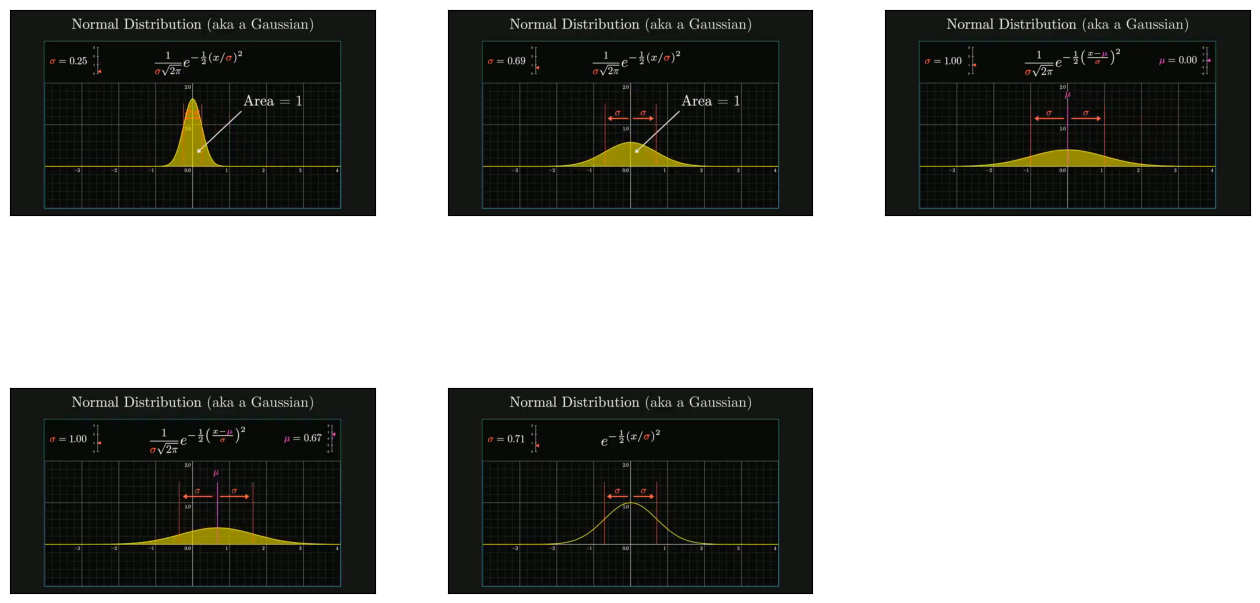

In [47]:
query_str = "Using examples from video, explain all things covered in the video regarding the gaussian function"

img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)
image_documents = SimpleDirectoryReader(
    input_dir=output_folder, input_files=img
).load_data()
context_str = "".join(txt)
plot_images(img)